# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1-oracle.run2",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/mnt/wd500GB/CSC500/csc500-main/datasets/oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_14', 'ORACLE.run2_32', 'ORACLE.run2_26', 'ORACLE.run2_38', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_44'}


{'ORACLE.run1_14', 'ORACLE.run1_50', 'ORACLE.run1_20', 'ORACLE.run1_38', 'ORACLE.run1_32', 'ORACLE.run1_26', 'ORACLE.run1_8', 'ORACLE.run1_44'}


tensor([[[ 0.3274, -0.4136, -1.3096,  ..., -0.9305, -0.2757,  0.5514],
         [ 0.3963, -0.1896,  0.3274,  ...,  0.4825,  0.0345,  0.7754]],

        [[ 0.9010, -0.3400, -0.3740,  ..., -0.2890,  0.5100,  0.7650],
         [ 0.3230,  0.2210, -0.0850,  ..., -0.0510, -0.5440, -0.9350]],

        [[ 0.2512,  0.9882, -0.0167,  ..., -0.2177,  1.0384,  0.1172],
         [-0.8374, -0.3182, -1.2729,  ...,  1.0719, -0.3015, -1.2729]],

        ...,

        [[-0.1919, -0.5905, -0.0148,  ...,  0.2510,  0.7676,  0.4872],
         [-0.2214, -0.7972,  0.7972,  ...,  0.9891,  1.2843, -0.4724]],

        [[ 0.5114,  0.0150,  0.0301,  ..., -0.9778, -0.6619,  0.0000],
         [-1.1432, -0.0752,  0.7822,  ...,  0.6619,  0.3761, -0.8875]],

        [[ 1.1993,  0.3748, -0.9145,  ..., -0.1499, -0.1949, -0.2698],
         [ 0.5547,  1.7540,  0.3148,  ...,  0.3448, -0.3448, -0.2399]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 9.6266, train_label_loss: 2.7554, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 3199.6733, train_label_loss: 1.2205, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3201.0331, train_label_loss: 0.7259, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3200.6698, train_label_loss: 1.6015, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3188.5953, train_label_loss: 0.7754, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3199.2965, train_label_loss: 0.4175, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3202.1151, train_label_loss: 0.7832, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3193.5786, train_label_loss: 1.5291, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3196.9731, train_label_loss: 1.4190, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 3199.2238, train_label_loss: 0.8627, 


epoch: 1, source_val_acc_label: 0.6366, target_val_acc_label: 0.6474, source_val_label_loss: 0.9841, target_val_label_loss: 0.9501, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9640, train_label_loss: 1.3685, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 3207.2532, train_label_loss: 0.7555, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 3226.5349, train_label_loss: 0.7908, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 3230.1220, train_label_loss: 1.3916, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3215.7285, train_label_loss: 0.4671, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3231.0473, train_label_loss: 0.7623, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3230.5234, train_label_loss: 0.9757, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3220.0363, train_label_loss: 0.7856, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3233.0634, train_label_loss: 1.3604, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3237.6965, train_label_loss: 0.4630, 


epoch: 2, source_val_acc_label: 0.6590, target_val_acc_label: 0.6682, source_val_label_loss: 0.9149, target_val_label_loss: 0.8787, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.9673, train_label_loss: 0.4436, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 3218.0831, train_label_loss: 1.0264, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3232.5748, train_label_loss: 1.2133, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3234.7082, train_label_loss: 0.5218, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3213.4414, train_label_loss: 0.8376, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 3224.1263, train_label_loss: 0.8217, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 3231.2154, train_label_loss: 0.3793, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 3224.3641, train_label_loss: 1.1029, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3230.6362, train_label_loss: 0.5764, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3231.5944, train_label_loss: 1.2053, 


epoch: 3, source_val_acc_label: 0.6878, target_val_acc_label: 0.6955, source_val_label_loss: 0.8515, target_val_label_loss: 0.8159, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.9673, train_label_loss: 1.1447, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 3203.8041, train_label_loss: 0.6205, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3226.2814, train_label_loss: 0.9055, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3231.6386, train_label_loss: 0.8263, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3229.6640, train_label_loss: 0.4878, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 3228.1500, train_label_loss: 0.7431, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 3236.8611, train_label_loss: 0.6854, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 3224.4623, train_label_loss: 1.0692, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3226.4167, train_label_loss: 0.3325, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3238.1192, train_label_loss: 0.9391, 


epoch: 4, source_val_acc_label: 0.7119, target_val_acc_label: 0.7171, source_val_label_loss: 0.7983, target_val_label_loss: 0.7711, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.9668, train_label_loss: 0.8276, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 3214.1790, train_label_loss: 0.3399, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3233.1635, train_label_loss: 0.5436, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3235.9106, train_label_loss: 0.5481, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 3220.6223, train_label_loss: 0.4963, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3239.0823, train_label_loss: 1.1640, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 3230.0700, train_label_loss: 0.5472, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 3225.4600, train_label_loss: 0.8595, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3232.0242, train_label_loss: 0.8599, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3237.6429, train_label_loss: 0.7542, 


epoch: 5, source_val_acc_label: 0.7188, target_val_acc_label: 0.7223, source_val_label_loss: 0.7736, target_val_label_loss: 0.7521, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.9673, train_label_loss: 0.2378, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 3213.5407, train_label_loss: 1.1342, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3233.0012, train_label_loss: 0.4775, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3233.9591, train_label_loss: 0.5640, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 3226.5221, train_label_loss: 0.4637, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3227.9984, train_label_loss: 0.3966, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 3235.6015, train_label_loss: 0.8535, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 3218.9622, train_label_loss: 0.6820, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3227.0333, train_label_loss: 0.5447, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3238.5488, train_label_loss: 0.6047, 


epoch: 6, source_val_acc_label: 0.7282, target_val_acc_label: 0.7311, source_val_label_loss: 0.7553, target_val_label_loss: 0.7352, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.9624, train_label_loss: 0.1597, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 3205.1841, train_label_loss: 0.4303, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3228.5615, train_label_loss: 0.3833, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3235.3362, train_label_loss: 0.6550, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 3222.1920, train_label_loss: 0.7796, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 3228.0052, train_label_loss: 0.3216, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 3231.0138, train_label_loss: 0.4129, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 3226.5808, train_label_loss: 0.8039, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3231.2968, train_label_loss: 0.5398, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3228.6499, train_label_loss: 0.3871, 


epoch: 7, source_val_acc_label: 0.7340, target_val_acc_label: 0.7363, source_val_label_loss: 0.7679, target_val_label_loss: 0.7502, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.9656, train_label_loss: 0.4051, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 3206.5167, train_label_loss: 0.3362, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3230.6075, train_label_loss: 0.3133, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3233.2539, train_label_loss: 0.5936, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 3215.6192, train_label_loss: 0.3637, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 3223.8141, train_label_loss: 0.5655, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 3232.3787, train_label_loss: 0.3802, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 3213.9433, train_label_loss: 0.2147, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3225.5938, train_label_loss: 0.8292, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3235.3788, train_label_loss: 0.2513, 


epoch: 8, source_val_acc_label: 0.7338, target_val_acc_label: 0.7354, source_val_label_loss: 0.7647, target_val_label_loss: 0.7508, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.9670, train_label_loss: 0.3746, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3205.3667, train_label_loss: 0.3557, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3224.1396, train_label_loss: 0.4418, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 3235.4780, train_label_loss: 0.3300, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3216.9222, train_label_loss: 0.6186, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3229.0141, train_label_loss: 0.4213, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3235.0645, train_label_loss: 0.1507, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3224.7018, train_label_loss: 0.3739, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3231.6845, train_label_loss: 0.6489, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3230.5676, train_label_loss: 0.2666, 


epoch: 9, source_val_acc_label: 0.7341, target_val_acc_label: 0.7349, source_val_label_loss: 0.7875, target_val_label_loss: 0.7767, 


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.9713, train_label_loss: 0.4983, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3208.5721, train_label_loss: 0.2174, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3226.7837, train_label_loss: 0.3761, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3227.7291, train_label_loss: 0.7381, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3219.0770, train_label_loss: 0.4079, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 3223.8127, train_label_loss: 0.2084, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3229.0984, train_label_loss: 0.2361, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3216.8914, train_label_loss: 0.2594, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 3230.3940, train_label_loss: 0.3275, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3234.6169, train_label_loss: 0.5228, 


epoch: 10, source_val_acc_label: 0.7320, target_val_acc_label: 0.7307, source_val_label_loss: 0.7939, target_val_label_loss: 0.7843, 


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.9695, train_label_loss: 0.4655, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3206.0024, train_label_loss: 0.4129, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3225.2169, train_label_loss: 0.3038, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3231.1206, train_label_loss: 0.3119, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3217.6391, train_label_loss: 0.2802, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3232.7332, train_label_loss: 0.2410, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3235.8357, train_label_loss: 0.3605, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3218.8756, train_label_loss: 0.3847, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3223.4693, train_label_loss: 0.3344, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3232.2921, train_label_loss: 0.4487, 


epoch: 11, source_val_acc_label: 0.7270, target_val_acc_label: 0.7271, source_val_label_loss: 0.8270, target_val_label_loss: 0.8190, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

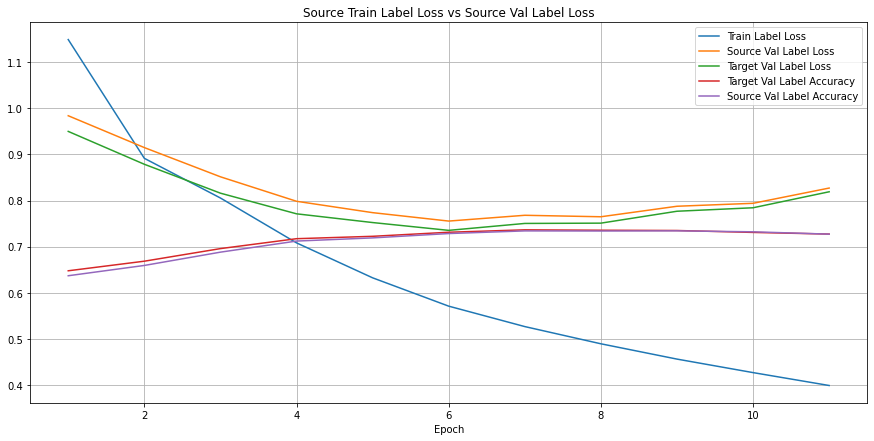

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

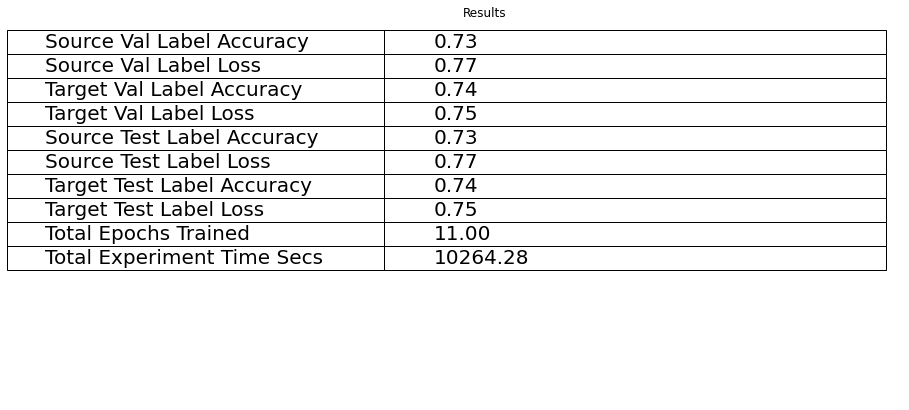

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

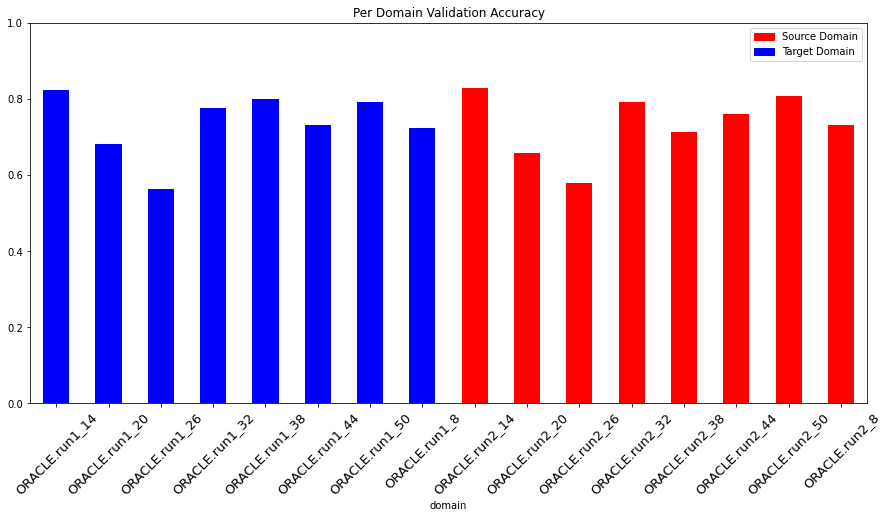

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7333203125 Target Test Label Accuracy: 0.73576171875
Source Val Label Accuracy: 0.73400390625 Target Val Label Accuracy: 0.7363151041666667


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "parameters": {"experiment_name": "tl_1v2:oracle.run1-oracle.run2", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"